In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [2]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar_df.head()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,0,4,2,4,1.302547e+05,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,0,1,4,4,0.000000e+00,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,0,1,4,6,2.581306e+05,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,0,3,3,5,1.341009e+06,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,0,1,1,1,5.240306e+05,1209410,1,0,0,2,0,0,0,-1,0


In [3]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [4]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [5]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_final_test = final_test_df.iloc[:, 0]

In [6]:
# 전체 데이터와 사기 데이터의 분포가 똑같아서 뭔가 ~ 분류에 쓸데 없어보이는 컬럼제거
train_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'acc_type1',
       'insurance_site_aid_YN', 'police_site_aid_YN', 'total_prsn_cnt'],
      dtype='object')

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_df.values, i) for i in range(train_df.shape[1])]
vif["features"] = train_df.columns
vif

,VIF Factor,features
0,1.004049,fraud_YN
1,5.362191,car_model
2,5.444233,age_group
3,5.757838,cumulative_use_count
4,6.514144,pf_type
5,6.283298,start_hour
6,4.407132,duration
7,4.788582,accident_hour
8,1.494093,repair_cost
9,1.197566,insure_cost


In [8]:
# VIF 10이상인 변수 제거
train_df.drop(columns=['police_site_aid_YN', 'acc_type1'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'insurance_site_aid_YN',
       'total_prsn_cnt'],
      dtype='object')

In [9]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X.shape, y.shape

((12879, 14), (12879,))

### 1. Original Data

In [10]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [11]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([8991,   24]))

In [12]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) *100

0.26622296173044924

In [13]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1]/len(y_test) *100

0.2587991718426501

In [14]:
# 성능지표 반환 함수 생성
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [15]:
# confusion_matrix 생성함수
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    return confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
#     print('=> confusion matrix')
#     print(confusion)
#     print('====================')
    
#     print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
#     print('Recall: {0:.4f}, F1: {1:.4f}, AUC: {2:.4f}'.format(re, f1, auc))

In [21]:
# 모델과 데이터를 주면 confusion matrix를 출력하는 함수
def get_confusion(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)    
    return print_clf_eval(y_test, pred)

In [22]:
# 다수의 모델 confusin matrix 정리해서 DataFrame으로 반환
def get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['f0p0', 'fo0p1', 'f1p0', 'f1p1']
    tmp =[]
    
    for model in models:
        tmp.append(get_confusion(model, X_train, y_train, X_test, y_test))
    
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

### 분류모델 
- 1. Logistic Regression
- 2. Decision Tree
- 3. Random Forest
- 4. LightGBM
- 5. SVM

In [215]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_coufusion_pd(models, model_names, y_test, pred):
    col_names = ['f0p0', 'f0p1', 'f1p0', 'f1p1']
    tmp = pd.DataFrame()
    
    for model in models:
        tmp.append({'f0p0':confusion[0,0],
                   'f0p1':confusion[0,1],
                   'f1p0':confusion[1,0],
                   'f1p1':confusion[1,1]}, index=[model])
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [16]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

(3854, 0, 10, 0)

In [17]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

(3854, 0, 10, 0)

In [18]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=300)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

(3854, 0, 10, 0)

In [19]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

(3854, 0, 10, 0)

In [30]:
# svm
from sklearn import svm

svm_clf = svm.SVC(probability=True)
svm_clf.fit(X_train, y_train)
svm_pred= svm_clf.predict(X_test)

print_clf_eval(y_test, svm_pred)

(3854, 0, 10, 0)

In [23]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [24]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [31]:
# 5개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  4.992079019546509


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
DecisionTree,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
RandomForest,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
LightGBM,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
SVM,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0


In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  33.41609764099121


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.804089,0.005298,0.4,0.010458,0.602569,3103,751,6,4
DecisionTree,0.564700,0.003563,0.6,0.007084,0.582304,2176,1678,4,6
RandomForest,0.995083,0.000000,0.0,0.000000,0.498832,3845,9,10,0
LightGBM,0.994306,0.000000,0.0,0.000000,0.498443,3842,12,10,0
SVM,0.736542,0.004912,0.5,0.009728,0.618578,2841,1013,5,5


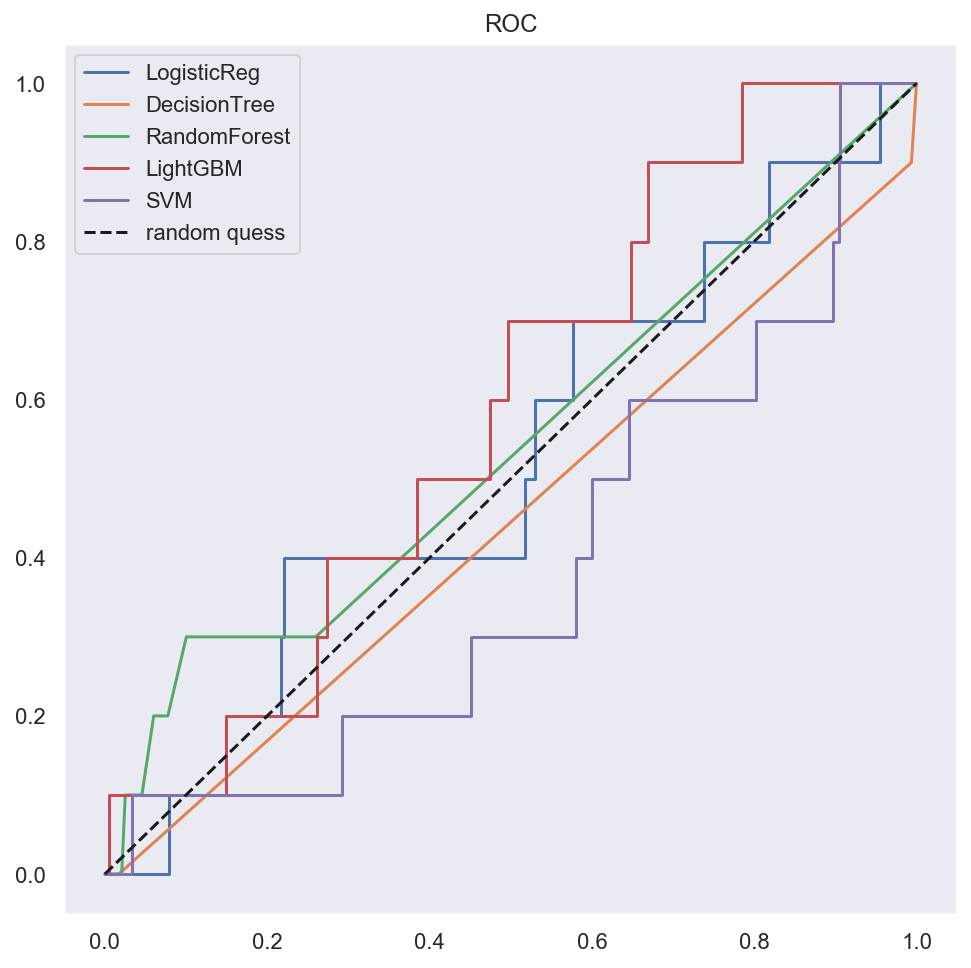

In [32]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

In [37]:
# train_df 에서 연속형 변수 가져와서 scaled feature 만들고
# target feature 및 original 연속형변수 삭제
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(train_df['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(train_df['repair_cost'].values.reshape(-1,1))

X_ss = train_df.drop(['fraud_YN', 'insure_cost', 'repair_cost'], axis=1) 
X_ss['scaled_insure_cost'] = insure_n
X_ss['scaled_repair_cost'] = repair_n

X_ss.head()

,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,3,2,2,4,2,4,1,0,1,0,-1,-0.273447,-0.296588
1,3,3,4,2,3,3,5,3,1,1,0,-1,-0.273447,2.047627
2,1,1,1,1,1,1,1,1,0,2,0,-1,0.121310,0.465826
3,1,3,4,3,6,3,1,0,0,1,2,2,0.123879,-0.548781
4,2,4,4,1,4,2,6,1,0,1,1,2,-0.273447,-0.548781


In [38]:
insure_log = np.log1p(train_df['insure_cost'])
repair_log = np.log1p(train_df['repair_cost'])

X_ls= train_df.drop(['insure_cost', 'repair_cost', 'fraud_YN'], axis=1) 
X_ls['scaled_insure_cost'] = insure_log
X_ls['scaled_repair_cost'] = repair_log

X_ls.head()

,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,3,2,2,4,2,4,1,0,1,0,-1,0.000000,11.777255
1,3,3,4,2,3,3,5,3,1,1,0,-1,0.000000,14.108934
2,1,1,1,1,1,1,1,1,0,2,0,-1,14.005644,13.169307
3,1,3,4,3,6,3,1,0,0,1,2,2,14.012130,0.000000
4,2,4,4,1,4,2,6,1,0,1,1,2,0.000000,0.000000


### 4. remove outlier

In [39]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [40]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)

Int64Index([92, 342, 3773], dtype='int64')

In [41]:
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)

Int64Index([12, 4576], dtype='int64')

In [71]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# origianl data 이상치 제거 
X_rmol = X.drop(outlier_index, axis=0)

# standard scaled data 이상치 제거 
X_ss_rmol = X_ss.drop(outlier_index, axis=0)

# log scaled data 이상치 제거
X_ls_rmol = X_ls.drop(outlier_index, axis=0)

# target 변수 이상치 제거 
y_rmol = y.drop(outlier_index, axis=0)

In [72]:
X_rmol.shape, X_ss_rmol.shape, X_ls_rmol.shape, y_rmol.shape

((12874, 14), (12874, 14), (12874, 14), (12874,))

### pca

In [149]:
from sklearn.decomposition import PCA

def get_pca_data(data, n_components=5):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    return pca.transform(data), pca

In [150]:
cols = ['pca_'+str(n+1) for n in range(pca.components_.shape[0])]
cols

['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7']

In [151]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n+1) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [152]:
# original pca

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [154]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [155]:
# original
socar_pca, pca = get_pca_data(X_train_over, n_components=5)
pca

PCA(n_components=5)

In [156]:
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_train_over
socar_pd_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17982 entries, 0 to 17981
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pca_1     17982 non-null  float64
 1   pca_2     17982 non-null  float64
 2   pca_3     17982 non-null  float64
 3   pca_4     17982 non-null  float64
 4   pca_5     17982 non-null  float64
 5   fraud_YN  17982 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 843.0 KB


In [157]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio: ', pca.explained_variance_ratio_)
    print('sum of variance_ratio: ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio:  [9.71375961e-01 2.86240388e-02 9.33282624e-13 3.31714339e-13
 2.79104026e-13]
sum of variance_ratio:  0.9999999999988868


In [158]:
socar_pca, pca = get_pca_data(X_train_over, n_components=3)
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_train_over
print_variance_ratio(pca)

variance_ratio:  [9.71375961e-01 2.86240388e-02 9.33282624e-13]
sum of variance_ratio:  0.9999999999982782


In [159]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  93.7844500541687


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.891535,0.000000,0.000000,0.000000,0.446809,3444,410,9,0
DecisionTree,0.758996,0.003233,0.333333,0.006403,0.546661,2929,925,6,3
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351,3849,5,9,0
LightGBM,0.995858,0.000000,0.000000,0.000000,0.499092,3847,7,9,0
SVM,0.227802,0.002676,0.888889,0.005335,0.557574,872,2982,1,8


In [160]:
# standard scale

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [162]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [163]:
socar_pca, pca = get_pca_data(X_train_over, n_components=7)
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_train_over
socar_pd_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,fraud_YN
0,-0.179440,1.241691,0.193998,-1.507127,1.962959,-0.613504,-0.033806,0
1,2.675937,0.936879,-1.572351,-0.612243,-0.427707,-0.807843,-1.444646,0
2,0.097053,1.126388,1.276428,-1.625705,0.189589,0.230510,-0.016026,0
3,-0.813647,-1.339694,1.307266,-0.298099,-0.010027,0.613475,-0.655812,0
4,0.212134,2.209605,1.892569,-1.274437,-0.197964,-0.220302,-0.077019,0


In [164]:
print_variance_ratio(pca)

variance_ratio:  [0.35539386 0.12518128 0.08864307 0.07523518 0.06852374 0.06010532
 0.05475955]
sum of variance_ratio:  0.8278420038313501


In [165]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  35.948076009750366


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.740357,0.002004,0.222222,0.003972,0.481895,2858,996,7,2
DecisionTree,0.827077,0.004511,0.333333,0.008902,0.580782,3192,662,6,3
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351,3849,5,9,0
LightGBM,0.994046,0.000000,0.000000,0.000000,0.498184,3840,14,9,0
SVM,0.950557,0.005435,0.111111,0.010363,0.531814,3671,183,8,1


In [ ]:
# logscale 된 변수 사용

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ls_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [167]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [168]:
socar_pca, pca = get_pca_data(X_train_over, n_components=5)
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_train_over
socar_pd_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,fraud_YN
0,-7.157819,2.973201,-0.647509,0.864155,0.795430,0
1,5.604907,8.531014,2.206160,1.357021,-0.216663,0
2,-7.122713,2.788651,-0.379166,0.382661,1.715617,0
3,-1.839663,-8.775809,-0.397202,-1.536247,0.451121,0
4,-7.277395,2.966773,-0.268850,1.088243,2.265273,0


In [169]:
print_variance_ratio(pca)

variance_ratio:  [0.47459784 0.39302331 0.04799224 0.01663316 0.01268285]
sum of variance_ratio:  0.9449293919873696


In [170]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  40.112699031829834


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.747864,0.002064,0.222222,0.004090,0.485657,2887,967,7,2
DecisionTree,0.827077,0.004511,0.333333,0.008902,0.580782,3192,662,6,3
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351,3849,5,9,0
LightGBM,0.996117,0.000000,0.000000,0.000000,0.499222,3848,6,9,0
SVM,0.938908,0.000000,0.000000,0.000000,0.470550,3627,227,9,0


In [338]:
########## final test data 적용 ##############

In [110]:
# 불필요한 변수 삭제
socar_del = socar_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2'])
socar_del.head()

,fraud_YN,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,3,2,2,4,2,4,1.302547e+05,0,1,0,1,0,0,0,-1,0
1,0,1,4,4,3,1,4,4,0.000000e+00,0,1,1,2,1,1,1,0,1
2,0,1,4,4,3,1,4,6,2.581306e+05,12925040,3,1,2,1,1,1,0,1
3,0,3,3,4,2,3,3,5,1.341009e+06,0,3,1,1,0,0,0,-1,0
4,0,1,1,1,1,1,1,1,5.240306e+05,1209410,1,0,2,0,0,0,-1,0


In [111]:
# train set 에서 타겟변수의 이상치 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['test_set']==0]
    fraud = fraud[fraud["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [112]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=socar_del, column="insure_cost", weight=1.5)) + list(get_outlier(df=socar_del, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# raw_data에서 이상치부터 제거
socar_rm_ol = socar_del.drop(outlier_index, axis=0)
socar_rm_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               15995 non-null  int64  
 1   car_model              15995 non-null  int64  
 2   age_group              15995 non-null  int64  
 3   cumulative_use_count   15995 non-null  int64  
 4   pf_type                15995 non-null  int64  
 5   start_hour             15995 non-null  int64  
 6   duration               15995 non-null  int64  
 7   accident_hour          15995 non-null  int64  
 8   repair_cost            15995 non-null  float64
 9   insure_cost            15995 non-null  int64  
 10  accident_location      15995 non-null  int64  
 11  car_part1              15995 non-null  int64  
 12  repair_cnt             15995 non-null  int64  
 13  acc_type1              15995 non-null  int64  
 14  insurance_site_aid_YN  15995 non-null  int64  
 15  po

In [113]:
# standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(socar_rm_ol['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(socar_rm_ol['repair_cost'].values.reshape(-1,1))

socar_ss_df = socar_rm_ol.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ss_df['scaled_insure_cost'] = insure_n
socar_ss_df['scaled_repair_cost'] = repair_n
socar_ss_df.tail()

,fraud_YN,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set,scaled_insure_cost,scaled_repair_cost
15995,0,2,2,2,2,1,1,1,1,1,1,0,0,0,-1,0,-0.277444,-0.551438
15996,0,2,2,4,1,5,2,6,2,1,1,0,0,0,-1,0,-0.277444,0.646717
15997,0,2,2,4,1,1,3,5,0,0,1,0,0,0,-1,1,-0.277444,-0.551438
15998,0,2,2,2,2,6,1,2,4,1,1,0,0,0,-1,0,-0.277444,-0.551438
15999,0,2,2,1,1,6,5,6,2,0,1,0,0,0,-1,0,0.106978,0.207165


In [114]:
train_df = socar_ss_df[socar_ss_df.test_set == 0]
final_test_df = socar_ss_df[socar_ss_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [115]:
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

In [116]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

X_train_over.shape, y_train_over.shape, X.shape, y.shape

((25690, 16), (25690,), (12874, 16), (12874,))

In [122]:
socar_pca, pca = get_pca_data(X_train_over, n_components=7)
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_rmol
socar_pd_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,fraud_YN
0,-1.113636,0.514111,-0.648561,0.191455,-0.543125,0.362848,-0.461825,0.0
1,-1.315035,1.666858,-0.863209,2.255142,0.521127,-0.593131,2.011632,0.0
2,3.418602,-0.050847,-1.690009,-0.798852,0.630712,-0.502562,-0.806005,0.0
3,0.063514,0.497885,4.874668,-0.709336,-0.474932,0.969520,0.193254,1.0
4,-2.663741,-0.256728,1.899684,2.519106,1.492107,0.835864,-0.653419,0.0


In [123]:
print_variance_ratio(pca)

variance_ratio:  [0.32096846 0.1174286  0.10414449 0.08699708 0.07481165 0.06400134
 0.05818071]
sum of variance_ratio:  0.8265323445881158


In [124]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  78.72455596923828


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.728933,0.001189,0.142857,0.002358,0.436554,2274,840,6,1
DecisionTree,0.803909,0.003284,0.285714,0.006494,0.545394,2507,607,5,2
RandomForest,0.996155,0.000000,0.000000,0.000000,0.499197,3109,5,7,0
LightGBM,0.993912,0.000000,0.000000,0.000000,0.498073,3102,12,7,0
SVM,0.935277,0.005076,0.142857,0.009804,0.539958,2918,196,6,1


In [125]:
# log scaling 

In [126]:
insure_log = np.log1p(socar_rm_ol['insure_cost'])
repair_log = np.log1p(socar_rm_ol['repair_cost'])

socar_ls_df= socar_rm_ol.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ls_df['scaled_insure_cost'] = insure_log
socar_ls_df['scaled_repair_cost'] = repair_log

socar_ls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               15995 non-null  int64  
 1   car_model              15995 non-null  int64  
 2   age_group              15995 non-null  int64  
 3   cumulative_use_count   15995 non-null  int64  
 4   pf_type                15995 non-null  int64  
 5   start_hour             15995 non-null  int64  
 6   duration               15995 non-null  int64  
 7   accident_hour          15995 non-null  int64  
 8   accident_location      15995 non-null  int64  
 9   car_part1              15995 non-null  int64  
 10  repair_cnt             15995 non-null  int64  
 11  acc_type1              15995 non-null  int64  
 12  insurance_site_aid_YN  15995 non-null  int64  
 13  police_site_aid_YN     15995 non-null  int64  
 14  total_prsn_cnt         15995 non-null  int64  
 15  te

In [127]:
train_df = socar_ls_df[socar_ls_df.test_set == 0]
final_test_df = socar_ls_df[socar_ls_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

In [128]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

X_train_over.shape, y_train_over.shape, X.shape, y.shape

((25690, 16), (25690,), (12874, 16), (12874,))

In [129]:
socar_pca, pca = get_pca_data(X_train_over, n_components=5)
socar_pd_pca = get_pd_from_pca(socar_pca, pca.components_.shape[0])
socar_pd_pca['fraud_YN'] = y_rmol
socar_pd_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,fraud_YN
0,-6.770718,3.052411,-1.136855,-0.072415,0.245519,0.0
1,-7.438324,5.354244,-1.376401,-0.006138,2.694134,0.0
2,6.268609,8.269762,3.221638,-0.955219,-0.616146,0.0
3,10.161221,-4.708052,0.002399,3.752475,-0.881988,1.0
4,-3.326062,-8.286951,-2.545511,0.180680,2.115009,0.0


In [130]:
print_variance_ratio(pca)

variance_ratio:  [0.46834911 0.40200984 0.0417943  0.01646208 0.01415511]
sum of variance_ratio:  0.9427704392236864


In [132]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  83.2717661857605


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.744954,0.001264,0.142857,0.002506,0.444582,2324,790,6,1
DecisionTree,0.528036,0.002038,0.428571,0.004057,0.478415,1645,1469,4,3
RandomForest,0.994873,0.000000,0.000000,0.000000,0.498555,3105,9,7,0
LightGBM,0.993912,0.000000,0.000000,0.000000,0.498073,3102,12,7,0
SVM,0.909644,0.000000,0.000000,0.000000,0.455845,2839,275,7,0
